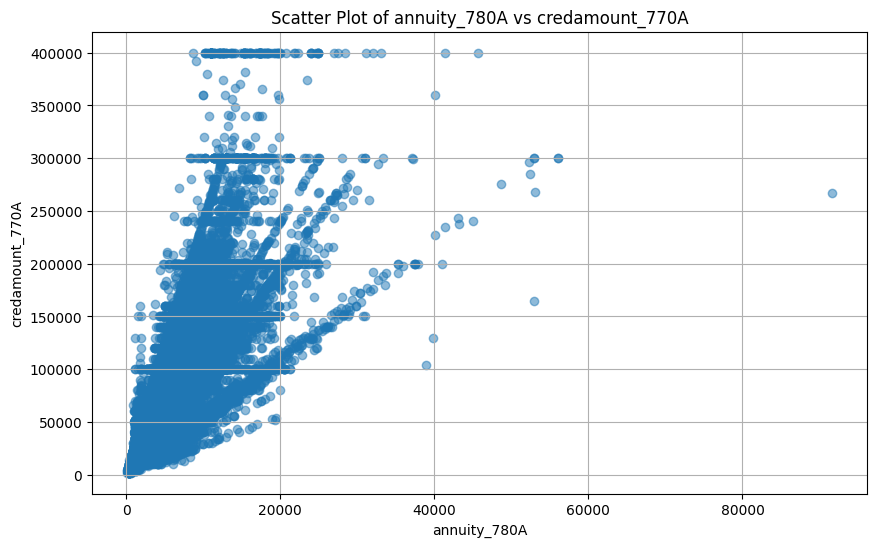

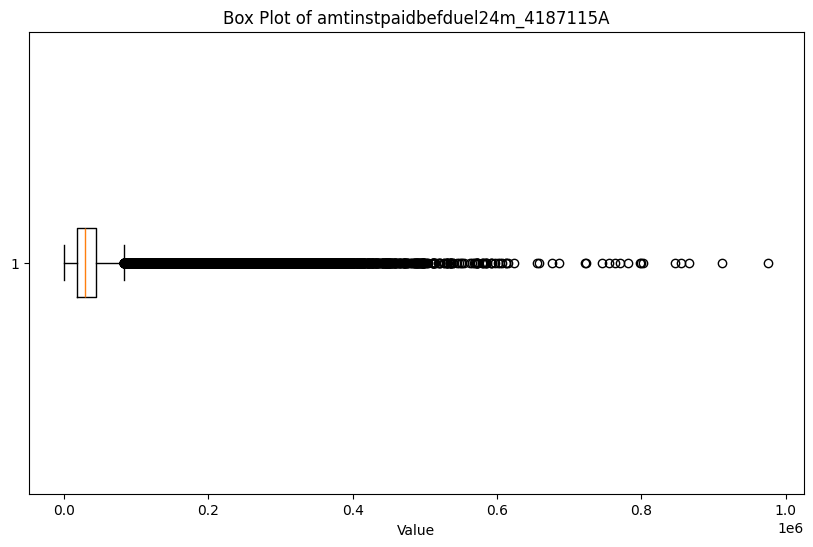

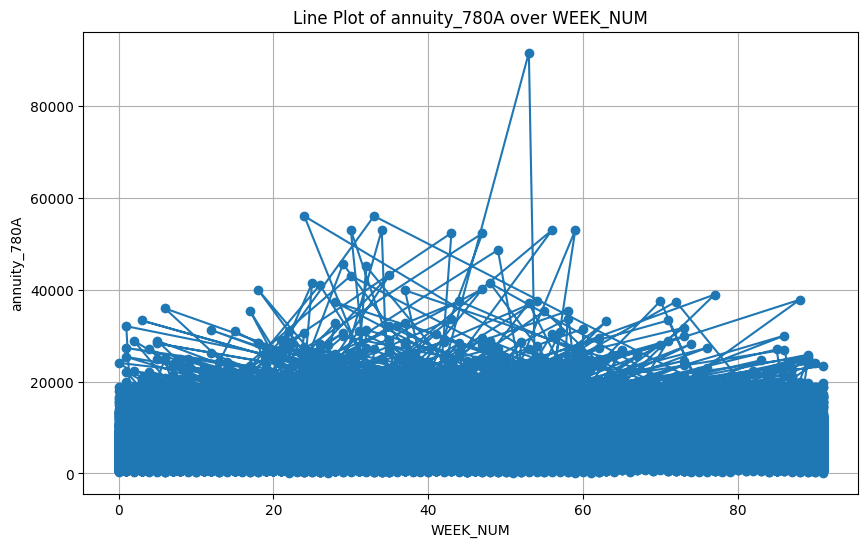

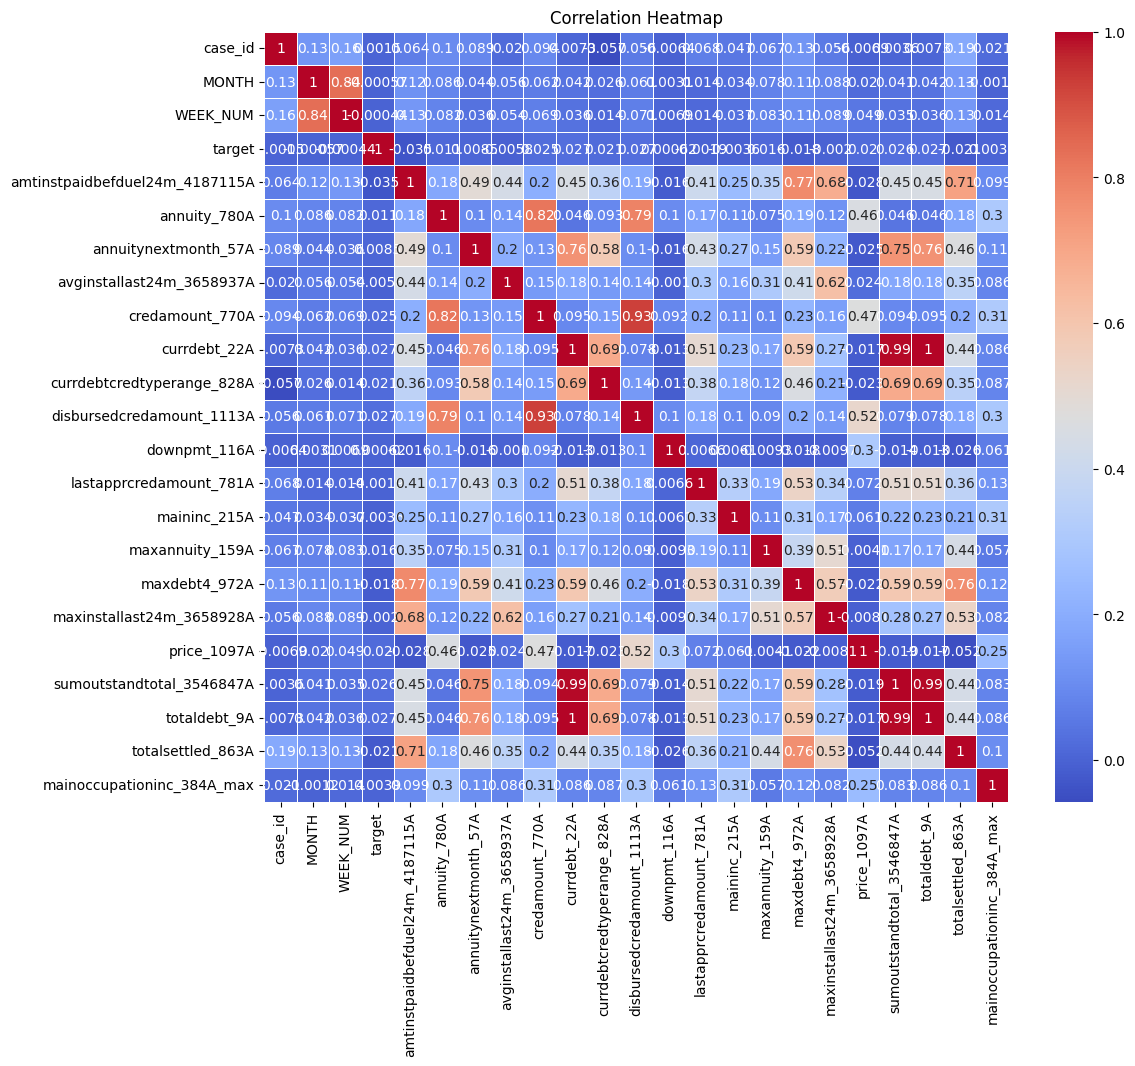

<Figure size 1200x1000 with 0 Axes>

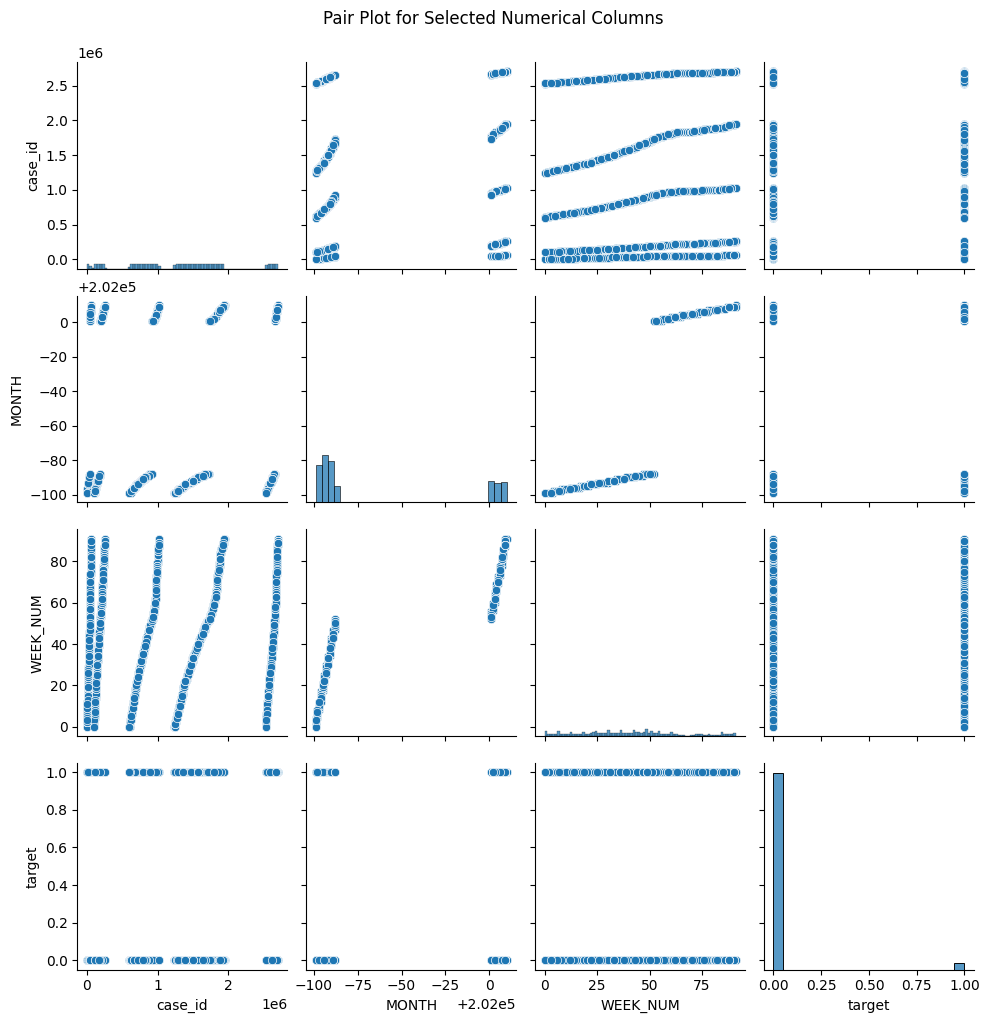

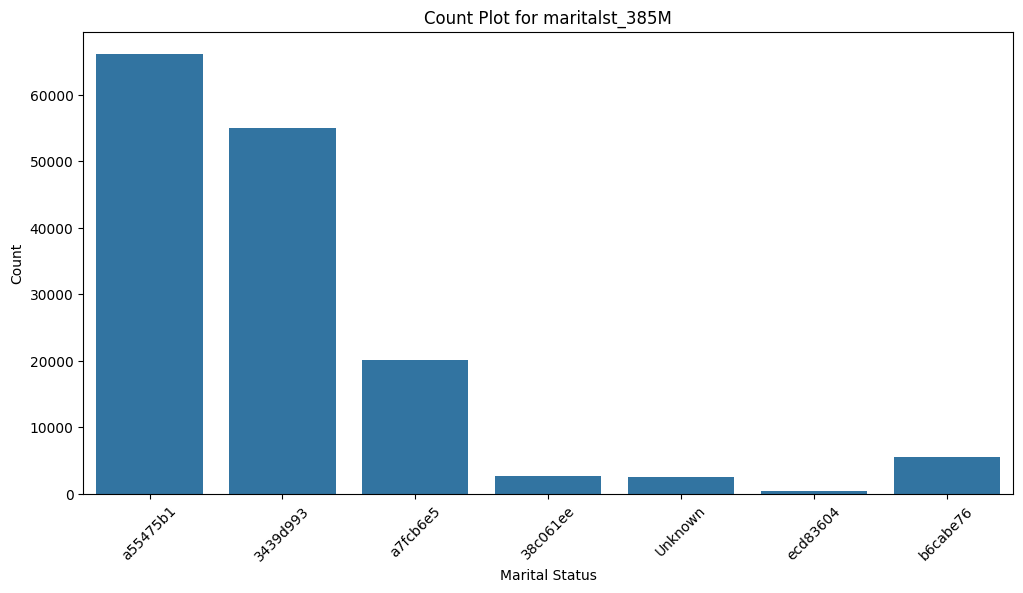

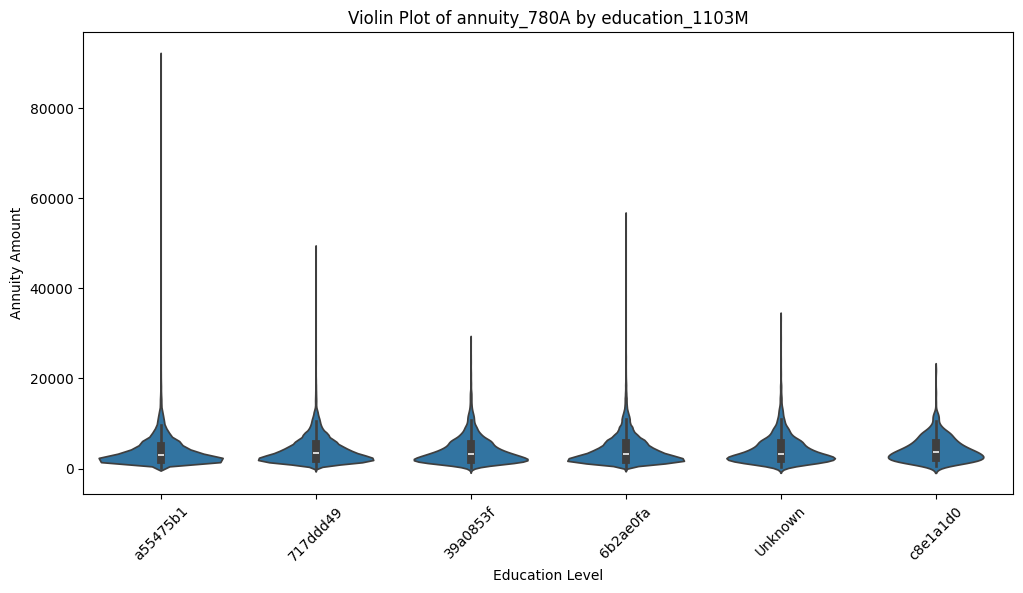

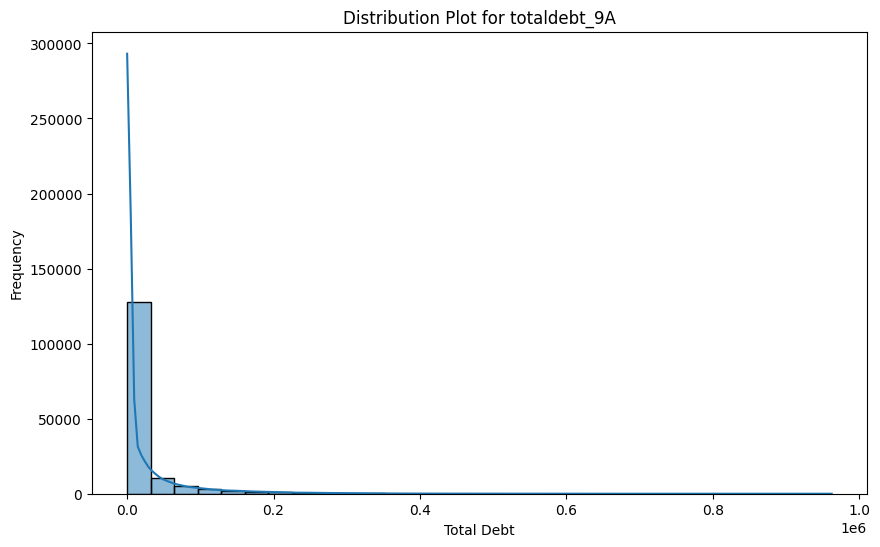

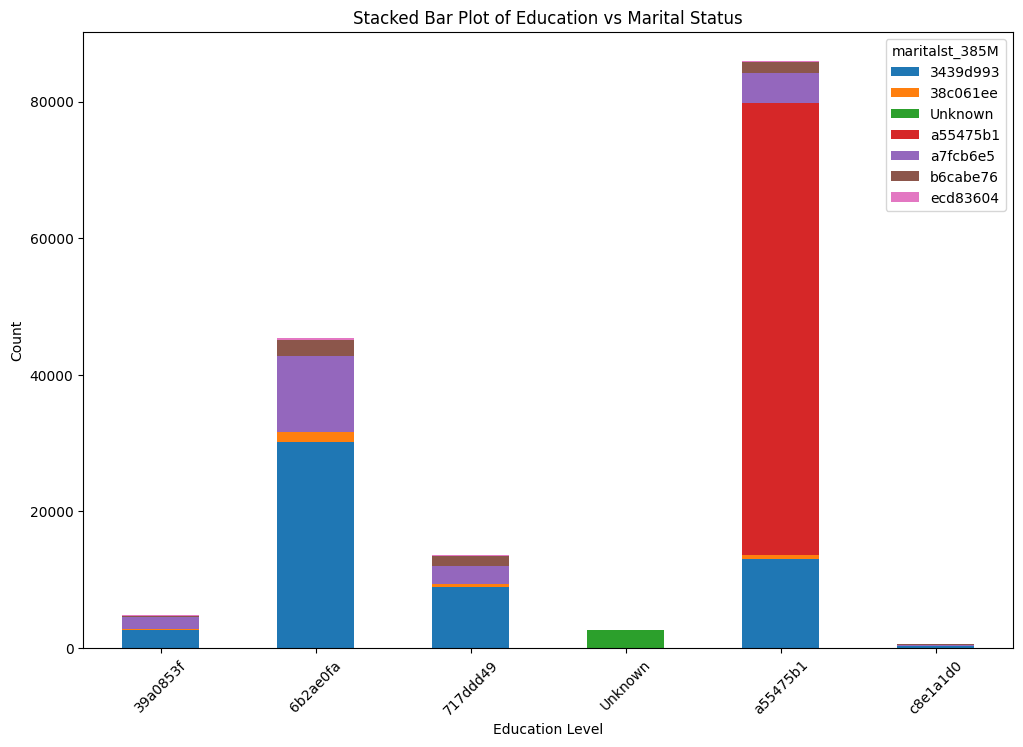

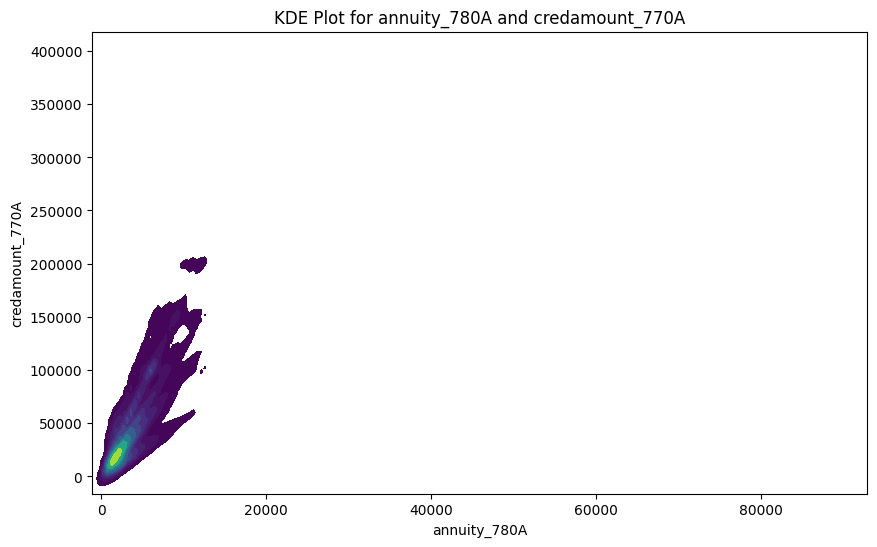

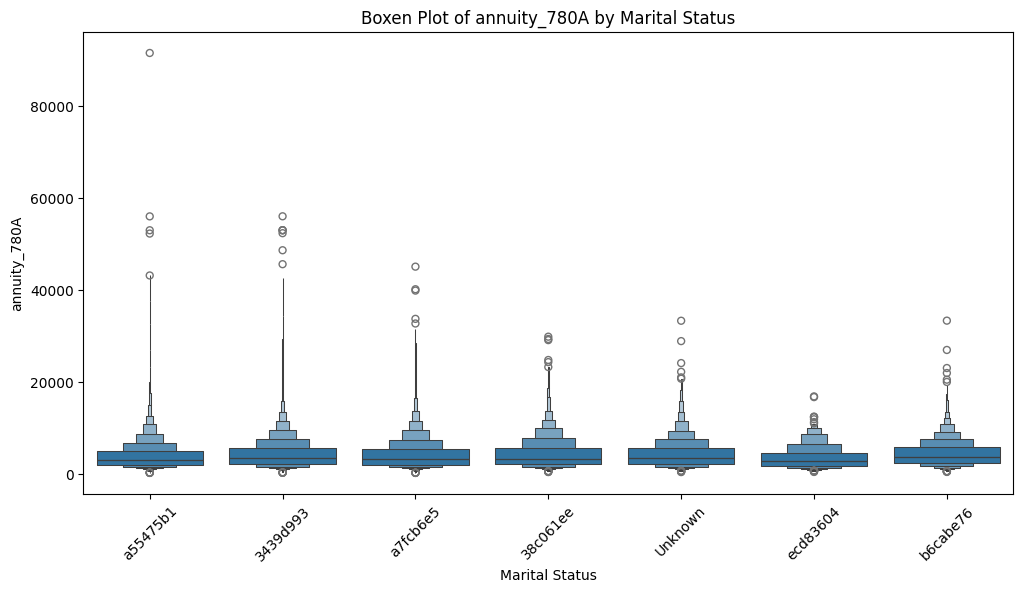

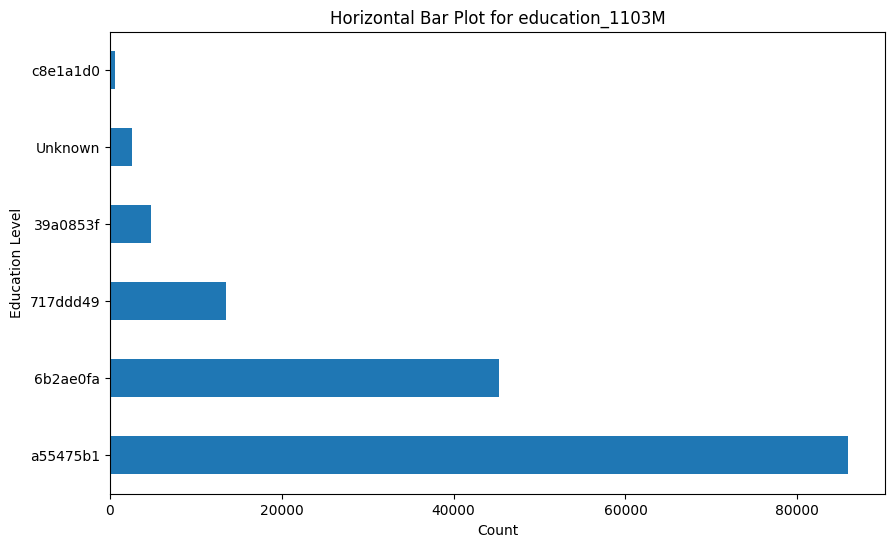

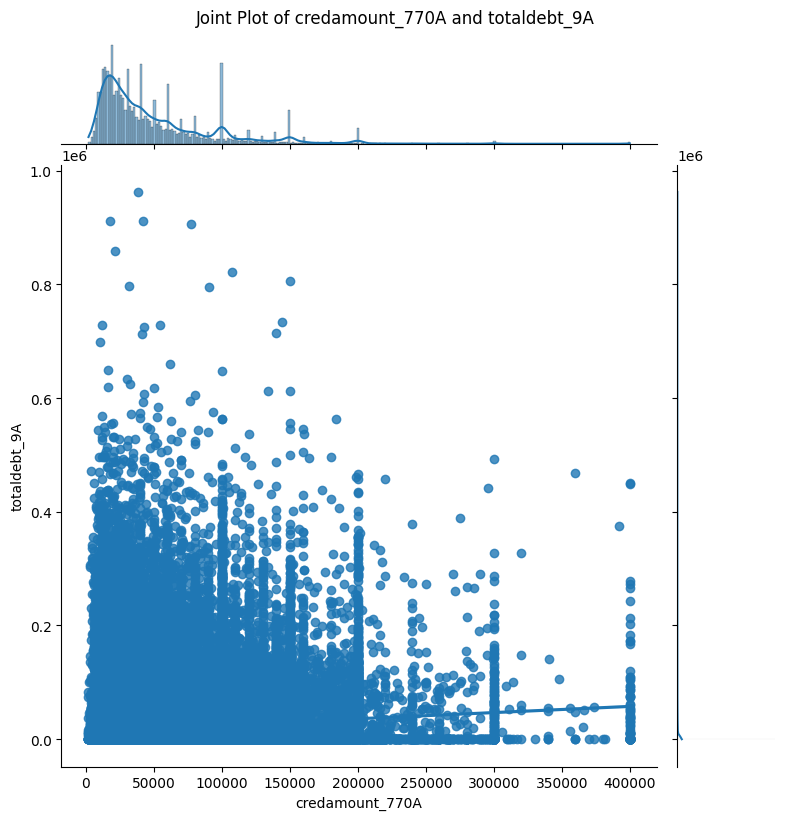

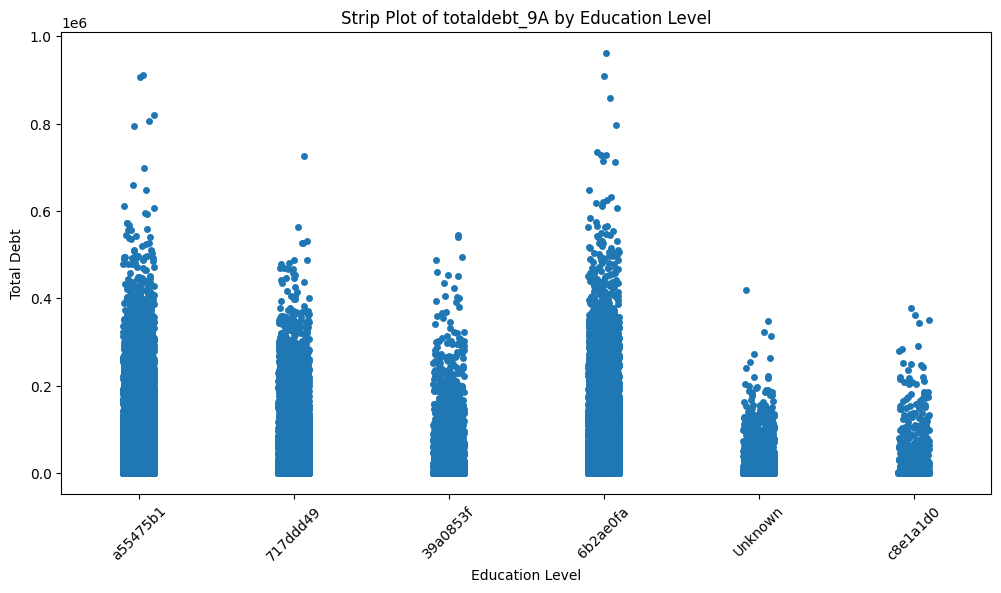

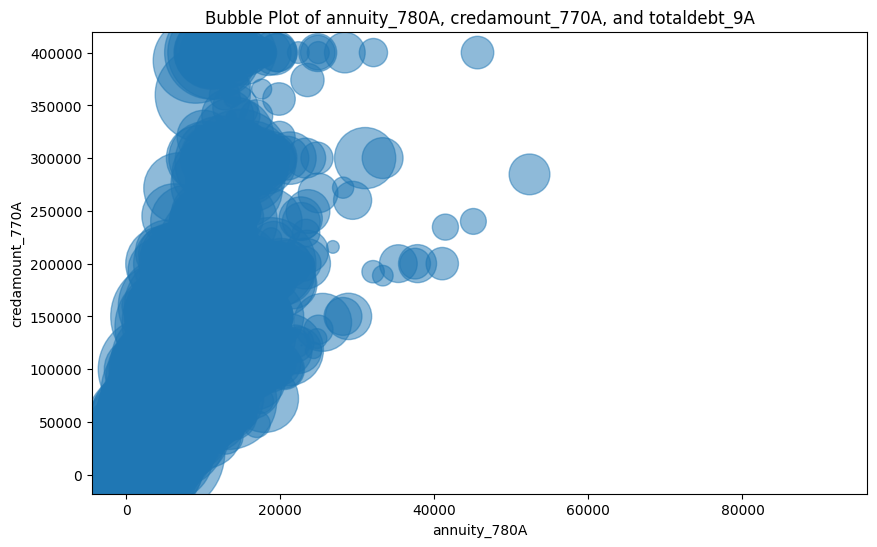

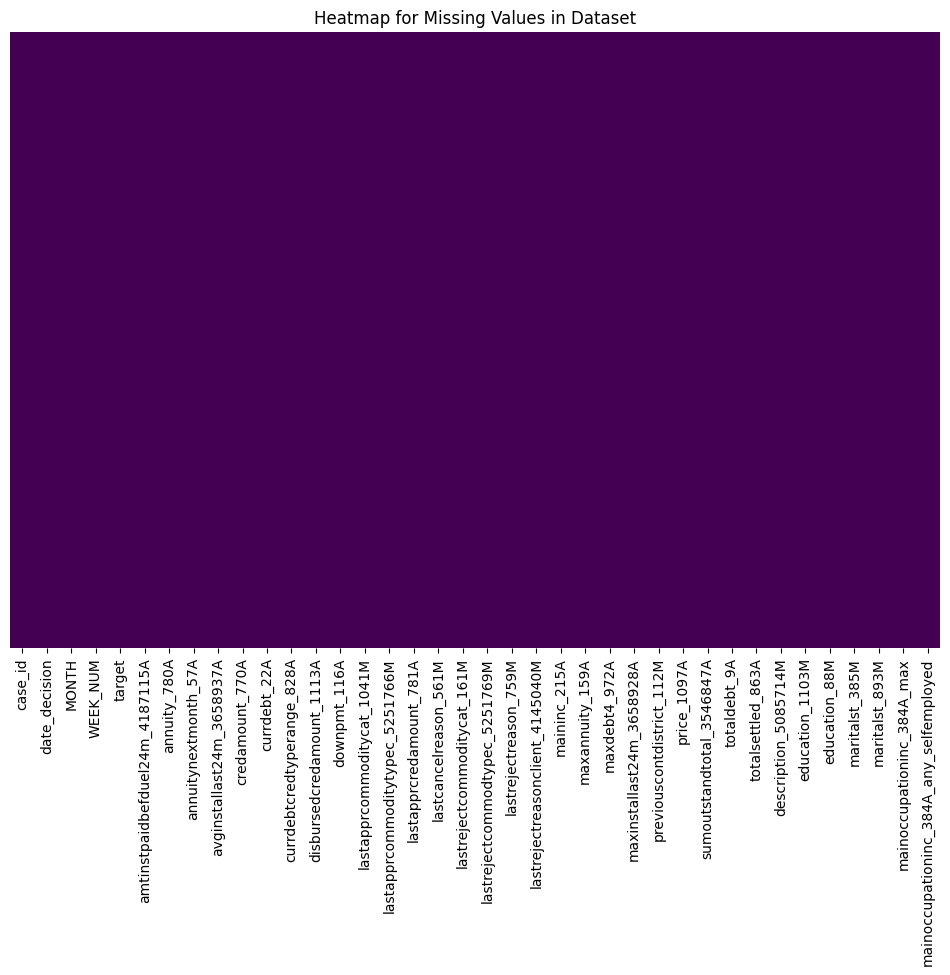

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, stddev, min, max, when

# Initialize a Spark session
spark = SparkSession.builder.appName("BigDataAnalysis").getOrCreate()

# Load the dataset
file_path = "downsampled_file.csv"  # Replace with your file path
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Data Cleaning

# 1. Drop columns with more than 50% missing values
threshold = 0.5 * df.count()
columns_to_keep = [c for c in df.columns if df.filter(col(c).isNotNull()).count() > threshold]
df = df.select(columns_to_keep)

# 2. Fill missing values for numerical columns with the median instead of mean
numerical_columns = [c for c, dtype in df.dtypes if dtype in ('int', 'double')]
for col_name in numerical_columns:
    median_value = df.approxQuantile(col_name, [0.5], 0.01)[0]
    df = df.fillna({col_name: median_value})

# 3. Fill missing values for categorical columns with 'Unknown'
categorical_columns = [c for c, dtype in df.dtypes if dtype == 'string']
for col_name in categorical_columns:
    df = df.na.fill(value="Unknown", subset=[col_name])

# 4. Remove duplicate rows
df = df.dropDuplicates()

# 5. Cap outliers for numerical columns (using the 1st and 99th percentiles)
for col_name in numerical_columns:
    lower_bound, upper_bound = df.approxQuantile(col_name, [0.01, 0.99], 0.01)
    df = df.withColumn(col_name, when(col(col_name) < lower_bound, lower_bound)
                                     .when(col(col_name) > upper_bound, upper_bound)
                                     .otherwise(col(col_name)))

# Convert Spark DataFrame to Pandas DataFrame for plotting
pandas_df = df.toPandas()

# Generate three different types of plots using cleaned data

# 1. Scatter Plot: Displaying relationship between two numerical columns (e.g., 'annuity_780A' vs 'credamount_770A')
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df['annuity_780A'], pandas_df['credamount_770A'], alpha=0.5)
plt.title('Scatter Plot of annuity_780A vs credamount_770A')
plt.xlabel('annuity_780A')
plt.ylabel('credamount_770A')
plt.grid(True)
plt.show()

# 2. Box Plot: Displaying distribution for a numerical column (e.g., 'amtinstpaidbefduel24m_4187115A')
plt.figure(figsize=(10, 6))
plt.boxplot(pandas_df['amtinstpaidbefduel24m_4187115A'].dropna(), vert=False)
plt.title('Box Plot of amtinstpaidbefduel24m_4187115A')
plt.xlabel('Value')
plt.show()

# 3. Line Plot: Displaying trend over time for a numerical column (e.g., 'WEEK_NUM' vs 'annuity_780A')
plt.figure(figsize=(10, 6))
plt.plot(pandas_df['WEEK_NUM'], pandas_df['annuity_780A'], marker='o', linestyle='-')
plt.title('Line Plot of annuity_780A over WEEK_NUM')
plt.xlabel('WEEK_NUM')
plt.ylabel('annuity_780A')
plt.grid(True)
plt.show()

#########################

#########################

# 1. Correlation Heatmap - Only for numerical columns
numerical_cols = pandas_df.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(12, 10))
sns.heatmap(pandas_df[numerical_cols].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# 2. Pair Plot (for a subset of columns)
# Select a few numerical columns that exist for visualization
pairplot_columns = numerical_cols[:4]  # Select the first 4 numerical columns
plt.figure(figsize=(12, 10))
sns.pairplot(pandas_df[pairplot_columns])
plt.suptitle('Pair Plot for Selected Numerical Columns', y=1.02)
plt.show()

# 3. Count Plot for Categorical Variable (e.g., 'maritalst_385M')
# Select a categorical column that exists
categorical_cols = pandas_df.select_dtypes(include=['object']).columns
if 'maritalst_385M' in categorical_cols:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=pandas_df, x='maritalst_385M')
    plt.title('Count Plot for maritalst_385M')
    plt.xlabel('Marital Status')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

# 4. Violin Plot for Numerical Column Distribution by Category
if 'education_1103M' in categorical_cols and 'annuity_780A' in numerical_cols:
    plt.figure(figsize=(12, 6))
    sns.violinplot(data=pandas_df, x='education_1103M', y='annuity_780A')
    plt.title('Violin Plot of annuity_780A by education_1103M')
    plt.xlabel('Education Level')
    plt.ylabel('Annuity Amount')
    plt.xticks(rotation=45)
    plt.show()

# 5. Distribution Plot for a Numerical Column
if 'totaldebt_9A' in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.histplot(pandas_df['totaldebt_9A'], kde=True, bins=30)
    plt.title('Distribution Plot for totaldebt_9A')
    plt.xlabel('Total Debt')
    plt.ylabel('Frequency')
    plt.show()

# 7. Stacked Bar Plot for Two Categorical Variables
if 'education_1103M' in categorical_cols and 'maritalst_385M' in categorical_cols:
    education_marital_count = pandas_df.groupby(['education_1103M', 'maritalst_385M']).size().unstack()
    education_marital_count.plot(kind='bar', stacked=True, figsize=(12, 8))
    plt.title('Stacked Bar Plot of Education vs Marital Status')
    plt.xlabel('Education Level')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

# 8. KDE Plot for Density Estimation
if 'annuity_780A' in numerical_cols and 'credamount_770A' in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=pandas_df, x='annuity_780A', y='credamount_770A', cmap='viridis', fill=True)
    plt.title('KDE Plot for annuity_780A and credamount_770A')
    plt.xlabel('annuity_780A')
    plt.ylabel('credamount_770A')
    plt.show()

# 9. Boxen Plot for Detailed Distribution Visualization
if 'annuity_780A' in numerical_cols and 'maritalst_385M' in categorical_cols:
    plt.figure(figsize=(12, 6))
    sns.boxenplot(data=pandas_df, x='maritalst_385M', y='annuity_780A')
    plt.title('Boxen Plot of annuity_780A by Marital Status')
    plt.xlabel('Marital Status')
    plt.ylabel('annuity_780A')
    plt.xticks(rotation=45)
    plt.show()

# 10. Sunburst Plot for Hierarchical Categorical Data Visualization
if 'education_1103M' in categorical_cols and 'maritalst_385M' in categorical_cols:
    fig = px.sunburst(pandas_df, path=['education_1103M', 'maritalst_385M'], title='Sunburst Plot for Education and Marital Status')
    fig.show()

# 11. Horizontal Bar Plot for Categorical Data
if 'education_1103M' in categorical_cols:
    plt.figure(figsize=(10, 6))
    pandas_df['education_1103M'].value_counts().plot(kind='barh')
    plt.title('Horizontal Bar Plot for education_1103M')
    plt.xlabel('Count')
    plt.ylabel('Education Level')
    plt.show()

# 12. Joint Plot for Visualizing Two Numerical Relationships
if 'credamount_770A' in numerical_cols and 'totaldebt_9A' in numerical_cols:
    sns.jointplot(data=pandas_df, x='credamount_770A', y='totaldebt_9A', kind='reg', height=8)
    plt.suptitle('Joint Plot of credamount_770A and totaldebt_9A', y=1.02)
    plt.show()

# 13. Strip Plot for Showing All Observations
if 'education_1103M' in categorical_cols and 'totaldebt_9A' in numerical_cols:
    plt.figure(figsize=(12, 6))
    sns.stripplot(data=pandas_df, x='education_1103M', y='totaldebt_9A')
    plt.title('Strip Plot of totaldebt_9A by Education Level')
    plt.xlabel('Education Level')
    plt.ylabel('Total Debt')
    plt.xticks(rotation=45)
    plt.show()

# 14. Bubble Plot
if 'annuity_780A' in numerical_cols and 'credamount_770A' in numerical_cols and 'totaldebt_9A' in numerical_cols:
    plt.figure(figsize=(10, 6))
    plt.scatter(pandas_df['annuity_780A'], pandas_df['credamount_770A'], s=pandas_df['totaldebt_9A'] / 100, alpha=0.5)
    plt.title('Bubble Plot of annuity_780A, credamount_770A, and totaldebt_9A')
    plt.xlabel('annuity_780A')
    plt.ylabel('credamount_770A')
    plt.show()

